# CTCF
[autosomal dominant intellectual developmental disorder-21 (MRD21)](https://omim.org/entry/615502) is caused by heterozygous mutation in the CTCF gene.

In [1]:
import gpsea
import hpotk

store = hpotk.configure_ontology_store()
hpo = store.load_minimal_hpo()
print(f'Loaded HPO v{hpo.version}')
print(f"Using gpsea version {gpsea.__version__}")

Loaded HPO v2025-01-16
Using gpsea version 0.9.4


# CTCF
We user the [Matched Annotation from NCBI and EMBL-EBI (MANE)](https://www.ncbi.nlm.nih.gov/refseq/MANE/) transcript and the corresponding protein identifier for CTCF.

In [2]:
gene_symbol = 'CTCF'
mane_tx_id = 'NM_006565.4'
mane_protein_id = 'NP_006556.1' # transcriptional repressor CTCF isoform 1

In [3]:
from ppktstore.registry import configure_phenopacket_registry
from gpsea.preprocessing import configure_caching_cohort_creator, load_phenopackets

from ppktstore.registry import configure_phenopacket_registry
phenopacket_registry = configure_phenopacket_registry()
with phenopacket_registry.open_phenopacket_store("0.1.24") as ps:
    phenopackets = tuple(ps.iter_cohort_phenopackets(gene_symbol))
len(phenopackets)


cohort_creator = configure_caching_cohort_creator(hpo)
cohort, validation = load_phenopackets(
    phenopackets=phenopackets, 
    cohort_creator=cohort_creator,
)

validation.summarize()

Individuals Processed: 100%|██████████| 46/46 [00:03<00:00, 12.85 individuals/s]
Validated under permissive policy
No errors or warnings were found


In [4]:
from gpsea.view import CohortViewer

viewer = CohortViewer(hpo=hpo)
viewer.process(cohort=cohort, transcript_id=mane_tx_id)

n,HPO Term
46,Intellectual disability
46,Global developmental delay
31,Feeding difficulties
31,Delayed speech and language development
22,Failure to thrive
22,Delayed ability to walk
19,Hypotonia
18,Microcephaly
18,Recurrent infections
13,Thin upper lip vermilion


/var/folders/hq/zttr8hjx127fgvh0bq7h4bc80000gn/T/ipykernel_1227/139479402.py:18: DeprecationWarning: draw_protein_diagram was deprecated and will be removed in `1.0.0`. Use `draw_protein` instead
  visualizer.draw_protein_diagram(


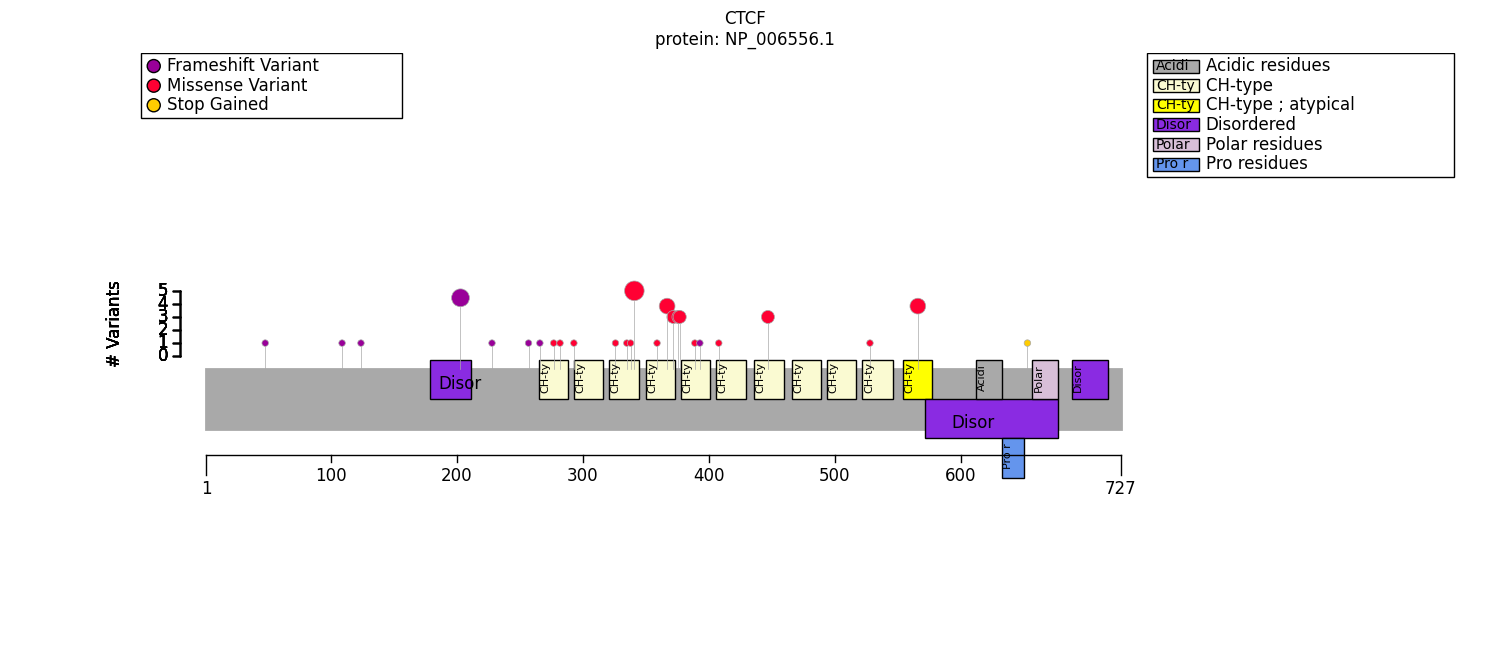

In [5]:
from gpsea.model.genome import GRCh38
from gpsea.model import ProteinMetadata
from gpsea.preprocessing import configure_default_protein_metadata_service, VVMultiCoordinateService
from gpsea.view import ProteinVisualizer
import matplotlib.pyplot as plt

txc_service = VVMultiCoordinateService(genome_build=GRCh38)
pms = configure_default_protein_metadata_service()
tx_coordinates = txc_service.fetch(mane_tx_id)
protein_meta = pms.annotate(mane_protein_id)

protein_meta = ProteinMetadata.from_uniprot_json(protein_id=mane_protein_id, label="CTCF",
                                                 uniprot_json="P49711.json",
                                                 protein_length=727)

ctcf_fig, ax = plt.subplots(figsize=(15, 8))
visualizer = ProteinVisualizer()
visualizer.draw_protein_diagram(
    tx_coordinates,
    protein_meta,
    cohort,
    ax=ax,
)
ctcf_fig.tight_layout()

In [6]:
from gpsea.view import ProteinVariantViewer
pvv = ProteinVariantViewer(protein_metadata=protein_meta, tx_id=mane_tx_id)
pvv.process(cohort=cohort)

Count,Name,Type,Coordinates,Variants
4,Disordered,Region,180 - 211,p.Lys206ProfsTer15
3,C2H2-type 1,Zinc finger,266 - 288,p.Cys268Ter; p.Arg278Leu; p.Arg283His
1,C2H2-type 2,Zinc finger,294 - 316,p.His294Pro
8,C2H2-type 3,Zinc finger,322 - 345,p.Arg342His; p.Arg339Gln; p.Arg342Cys; p.Cys327Ser; p.Glu336Gln
6,C2H2-type 4,Zinc finger,351 - 373,p.Ser360Arg; p.His373Asp; p.Arg368Cys; p.Arg368His; p.His373Pro
2,C2H2-type 5,Zinc finger,379 - 401,p.Asp390Asn; p.Arg396LysfsTer13
1,C2H2-type 6,Zinc finger,407 - 430,p.Cys409Tyr
2,C2H2-type 7,Zinc finger,437 - 460,p.Arg448Gln
0,C2H2-type 8,Zinc finger,467 - 489,
0,C2H2-type 9,Zinc finger,495 - 517,


# Genotype-Phenotype Correlation (GPC) Analysis

In [7]:
from gpsea.analysis.pcats import configure_hpo_term_analysis
analysis = configure_hpo_term_analysis(hpo)

from gpsea.analysis.clf import prepare_classifiers_for_terms_of_interest
pheno_clfs = prepare_classifiers_for_terms_of_interest(
    cohort=cohort,
    hpo=hpo,
)

In [8]:
from gpsea.model import VariantEffect
from gpsea.analysis.predicate import variant_effect
from gpsea.analysis.clf import monoallelic_classifier

missense = variant_effect(VariantEffect.MISSENSE_VARIANT, tx_id=mane_tx_id)

missense_clf = monoallelic_classifier(a_predicate=missense, 
                                     b_predicate=~missense, 
                                     a_label="missense", 
                                     b_label="other")
missense_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_clf=missense_clf,
    pheno_clfs=pheno_clfs,
)
from gpsea.view import MtcStatsViewer

viewer = MtcStatsViewer()
viewer.process(missense_result)

Code,Reason,Count
HMF01,Skipping term with maximum frequency that was less than threshold 0.4,96
HMF03,Skipping term because of a child term with the same individual counts,8
HMF08,Skipping general term,58
HMF09,Skipping term with maximum annotation frequency that was less than threshold 0.4,158


In [9]:
from gpsea.view import summarize_hpo_analysis

summarize_hpo_analysis(hpo=hpo, result=missense_result)

Allele group,missense,other,Corrected p values,p values
Feeding difficulties [HP:0011968],21/26 (81%),10/17 (59%),1.0,0.167940
Recurrent infections [HP:0002719],13/25 (52%),5/16 (31%),1.0,0.217876
Delayed speech and language development [HP:0000750],20/24 (83%),11/17 (65%),1.0,0.269731
Microcephaly [HP:0000252],9/25 (36%),9/16 (56%),1.0,0.333512
Hypotonia [HP:0001252],13/22 (59%),6/14 (43%),1.0,0.495469
Failure to thrive [HP:0001508],14/26 (54%),8/17 (47%),1.0,0.759670
Abnormal cerebral morphology [HP:0002060],10/10 (100%),10/10 (100%),1.0,1.000000
Abnormal brain morphology [HP:0012443],11/11 (100%),11/11 (100%),1.0,1.000000
Abnormal axial skeleton morphology [HP:0009121],12/12 (100%),11/11 (100%),1.0,1.000000
Morphological central nervous system abnormality [HP:0002011],13/13 (100%),12/12 (100%),1.0,1.000000


In [10]:
from gpsea.analysis.pscore import DeVriesPhenotypeScorer
pheno_scorer = DeVriesPhenotypeScorer(hpo)
pheno_scorer.description
from gpsea.analysis.pscore.stats import MannWhitneyStatistic
score_statistic = MannWhitneyStatistic()
from gpsea.analysis.pscore import PhenotypeScoreAnalysis
score_analysis = PhenotypeScoreAnalysis(
    score_statistic=score_statistic,
)
missense_devries_result = score_analysis.compare_genotype_vs_phenotype_score(
    cohort=cohort,
    gt_clf=missense_clf,
    pheno_scorer=pheno_scorer,
)
print(f"DeVries score, missense, p-value={missense_devries_result.pval:.5f}")

DeVries score, missense, p-value=0.00940


Text(1.2, 3.4, 'p-value=0.00940')

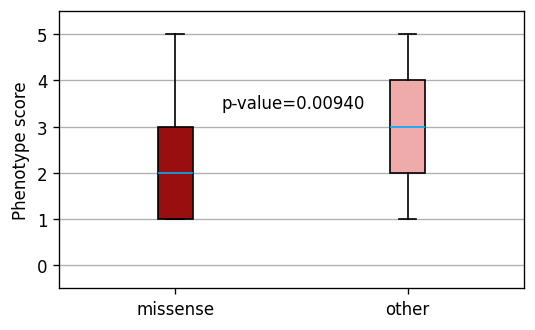

In [11]:
import matplotlib.pyplot as plt
devries_fig, ax = plt.subplots(figsize=(5, 3), dpi=120)
missense_devries_result.plot_boxplots(
    ax=ax,
)
ax.grid(axis="y")
ax.set(
    ylabel="Phenotype score", ylim=(-0.5, 5 + 0.5)
)
ax.text(x=1.2, y=3.4, s=f"p-value={missense_devries_result.pval:.5f}")

In [12]:
from gpsea.analysis.clf import sex_classifier
mf_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_clf=sex_classifier(),
    pheno_clfs=pheno_clfs,
)
summarize_hpo_analysis(hpo=hpo, result=mf_result)

Sex,FEMALE,MALE,Corrected p values,p values
Hypotonia [HP:0001252],12/17 (71%),7/19 (37%),0.838782,0.054282
Delayed speech and language development [HP:0000750],10/17 (59%),21/24 (88%),0.838782,0.063209
Delayed ability to walk [HP:0031936],12/17 (71%),10/23 (43%),0.838782,0.115875
Failure to thrive [HP:0001508],12/18 (67%),10/25 (40%),0.838782,0.124264
Feeding difficulties [HP:0011968],15/18 (83%),16/25 (64%),1.000000,0.191146
Recurrent infections [HP:0002719],9/17 (53%),9/24 (38%),1.000000,0.358329
Microcephaly [HP:0000252],9/18 (50%),9/23 (39%),1.000000,0.539412
Abnormal eyelid morphology [HP:0000492],10/10 (100%),10/10 (100%),1.000000,1.000000
Abnormal brain morphology [HP:0012443],10/10 (100%),12/12 (100%),1.000000,1.000000
Morphological central nervous system abnormality [HP:0002011],10/10 (100%),15/15 (100%),1.000000,1.000000


# Summary

In [13]:
from gpseacs.report import GpseaAnalysisReport, GPAnalysisResultSummary

m_results = (
    GPAnalysisResultSummary.from_mono(
        result=missense_devries_result
    ),
)

f_results = (
    GPAnalysisResultSummary.from_mono(
        result=missense_result,
    ),
)

caption = "To the bext of our knowledge, the association of missense variants with the DeVries severity score was not previously reported."
report = GpseaAnalysisReport(name=gene_symbol, 
                             cohort=cohort, 
                             fet_results=f_results,
                             mono_results=m_results,
                             gene_symbol=gene_symbol,
                             mane_tx_id=mane_tx_id,
                             mane_protein_id=mane_protein_id,
                             caption=caption)

In [14]:
from gpseacs.report import GpseaNotebookSummarizer
summarizer = GpseaNotebookSummarizer(hpo=hpo, gpsea_version=gpsea.__version__)
summarizer.summarize_report(report=report)

In [15]:
summarizer.process_latex(report=report, protein_fig=ctcf_fig, stats_fig=devries_fig)

Figure saved to ../../supplement/img/CTCF_protein_diagram-draft.pdf
Figure saved to ../../supplement/img/CTCF_stats-draft.pdf
Output to ../../supplement/tex/CTCF_summary_draft.tex
